In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
plt.rcParams['figure.figsize'] = (15, 8)
font = {'family' : 'verdana',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

# Чтение датасета

In [3]:
df = pd.read_csv("ks-projects-201801.csv", index_col=0)

In [4]:
len(df)

378661

In [5]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [6]:
df.nunique()

name                375764
category               159
main_category           15
currency                14
deadline              3164
goal                  8353
launched            378089
pledged              62130
state                    6
backers               3963
country                 23
usd pledged          95455
usd_pledged_real    106065
usd_goal_real        50339
dtype: int64

# Утиль

In [7]:
sns.set_palette(sns.color_palette("colorblind") + ["#9b59b6", "#a5b5c6", "#e71c5c", "#34495e", "#3edc81", "#507d50"])

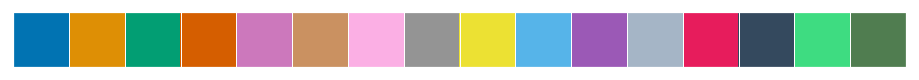

In [8]:
sns.palplot(sns.color_palette())

# Смотрим на подозрительные столбцы

Помимо столбцов с очевидным смыслом содержимого, есть несколько не очень понятных:
* **pledged** - сколько проекту поднесли согласно самому Кикстартеру, измеряя в исходных денежных единицах
* **goal** - тоже измеряется в исходных единицах
* **usd pledged** - сколько проекту поднесли согласно самому Кикстартеру, измеряя в единицах USD

Кикстартеровский перевод денежных единиц автору датасета не понравился (как минимум, он содержит наны, применён только к pledged и не применён к goal-у) и он воспользовался другим алгоритмом перевода.

* **usd_pledged_real** - сколько проекту поднесли в единицах USD согласно автору датасета
* **usd_goal_real** - автор датасета применил свой алгоритм и к goal, который измеряется в исходных денежных единицах

In [9]:
# считаем курсы валют, по которым был сделан пересчёт
df["usd pledged ratio"] = df["usd pledged"] / df.pledged
df["usd_pledged_real ratio"] = df["usd_pledged_real"] / df.pledged
df["usd_goal_real ratio"] = df["usd_goal_real"] / df.goal

Действительно, в переводе от Kickstarter-а явно содержится лажа.

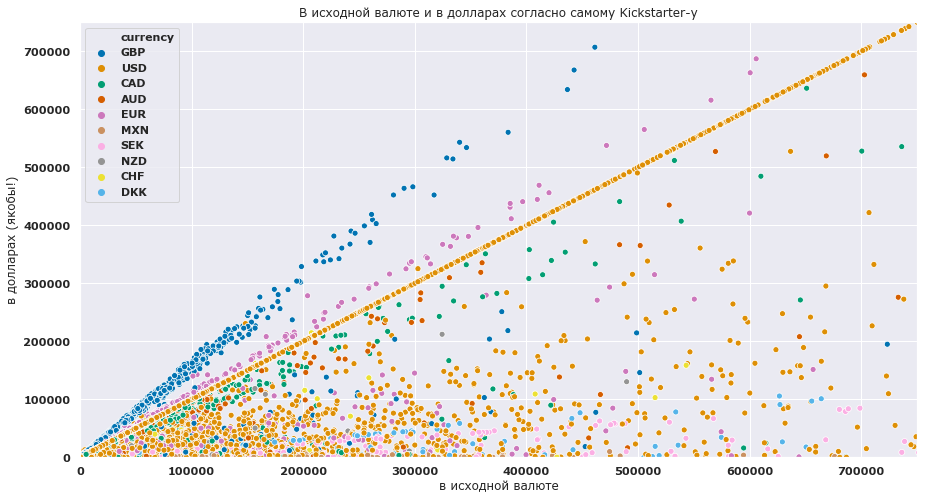

In [10]:
top_cur = df.currency.value_counts()[:10]
sns.scatterplot(x="pledged", y="usd pledged", hue="currency", data=df[df.currency.map(lambda x: x in top_cur)])

plt.title("В исходной валюте и в долларах согласно самому Kickstarter-у")
plt.xlabel("в исходной валюте")
plt.ylabel("в долларах (якобы!)")
plt.xlim(0, 750000)
plt.ylim(0, 750000)

plt.savefig("a_KScurrency.png", bbox_inches='tight')

Обратите внимание на доллар! Курс доллара к доллару не всегда 1.

Проверка на аналогичное безобразие для перевода от авторов датасета.

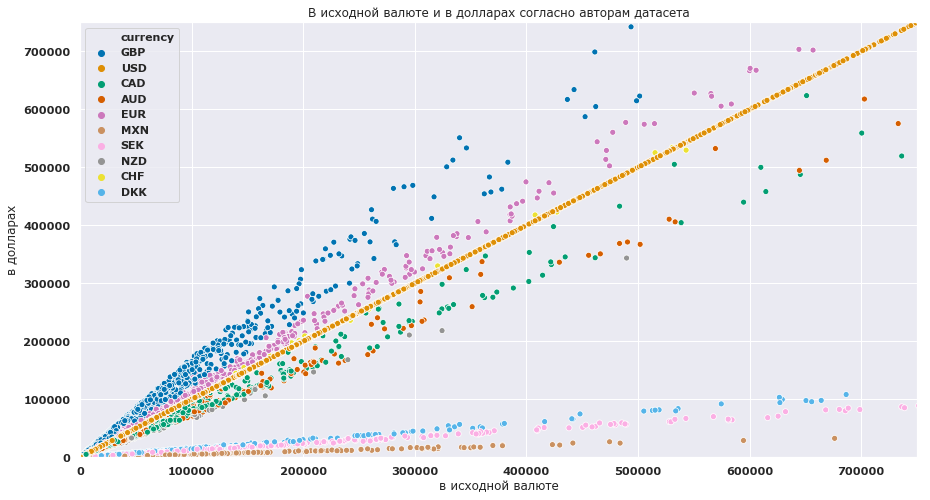

In [11]:
sns.scatterplot(x="pledged", y="usd_pledged_real", hue="currency", data=df[df.currency.map(lambda x: x in top_cur)])

plt.title("В исходной валюте и в долларах согласно авторам датасета")
plt.xlabel("в исходной валюте")
plt.ylabel("в долларах")
plt.xlim(0, 750000)
plt.ylim(0, 750000)
plt.savefig("b_DAcurrency.png", bbox_inches='tight')

#### ЖЕЛАНИЕ: избавиться от pledged, goal и usd pledged

Проблема: а как вообще составитель датасета пересчитал валюты, не зная точных дат каждого взноса? Курс же меняется от момента запуска проекта к концу проекта, а времени каждого взноса в датасете нет.

In [12]:
# сделаем датасет, отсортированный по времени: будет полезно
tdf = df.dropna().set_index("launched")
tdf.index = pd.to_datetime(tdf.index)

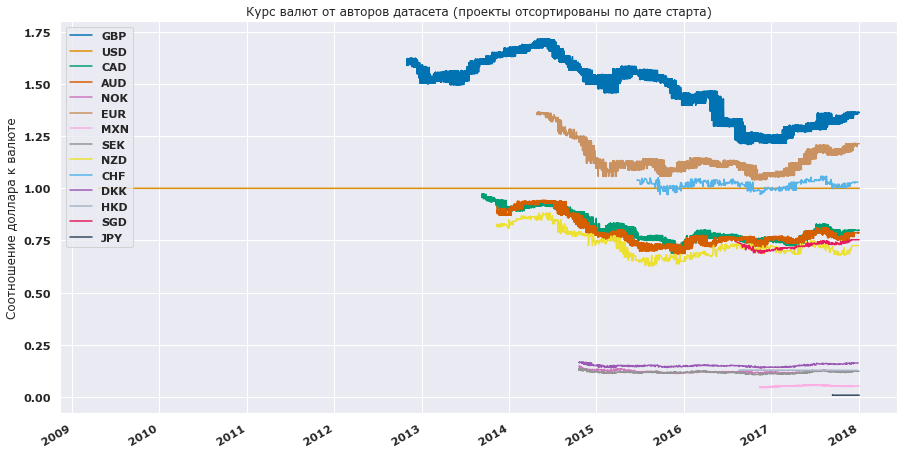

In [13]:
plt.title("Курс валют от авторов датасета (проекты отсортированы по дате старта)")
for val in df.currency.unique():
    tdf[tdf.currency == val]["usd_pledged_real ratio"].plot(label=val)
plt.legend()
plt.ylabel("Соотношение доллара к валюте")
plt.xlabel("")
plt.savefig("c_currencyBeginings.png", bbox_inches='tight')

Нет, SGD это сингапурский доллар.

Почему линия "дрожит": курс "в среднем по проекту" зависит также от даты окончания проекта. Возможно, если мы нарисуем график "курса валют" по goal-у, то есть заявленной открывшими проект целевой сумме, картинка изменится!

Text(0.5,0,'')

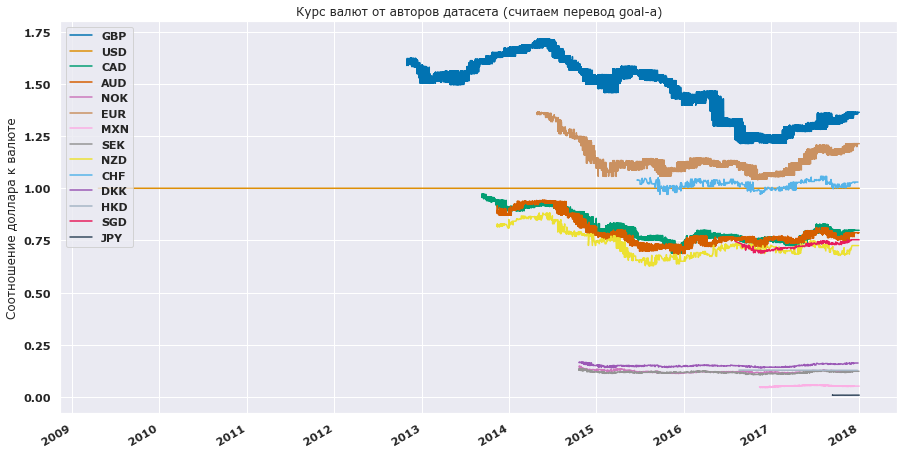

In [14]:
plt.title("Курс валют от авторов датасета (считаем перевод goal-а)")
for val in df.currency.unique():
    tdf[tdf.currency == val]["usd_goal_real ratio"].plot(label=val)
plt.legend()
plt.ylabel("Соотношение доллара к валюте")
plt.xlabel("")

Что ж, картинка такая же. Мы отсортировали по времени старта проекта, возможно, авторы делали перевод по курсу на момент окончания проекта!

In [15]:
tdf = df.dropna().set_index("deadline")
tdf.index = pd.to_datetime(tdf.index)

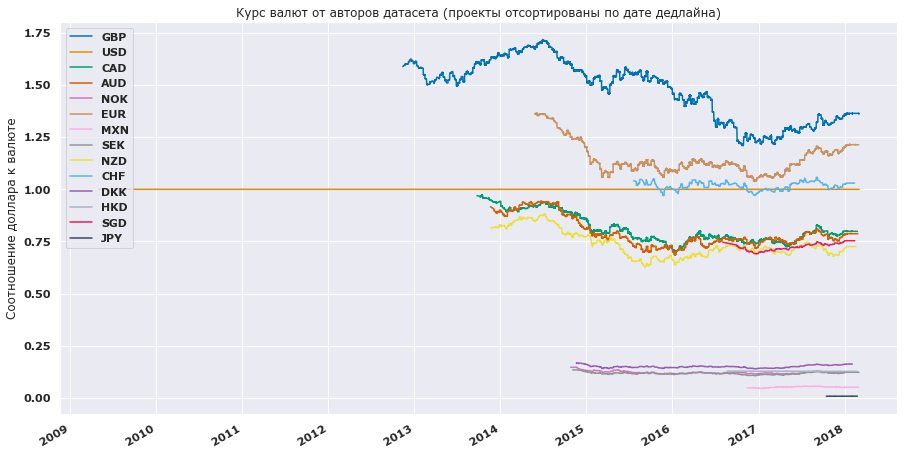

In [16]:
plt.title("Курс валют от авторов датасета (проекты отсортированы по дате дедлайна)")
for val in df.currency.unique():
    tdf[tdf.currency == val]["usd_pledged_real ratio"].plot(label=val)
plt.legend()
plt.ylabel("Соотношение доллара к валюте")
plt.xlabel("")
plt.savefig("d_currencyEndings.png", bbox_inches='tight')

Хмм, а с чем, интересно, связана разница между обработкой pledged и goal?
Очень похоже на погрешность вычислений, но как-то многовато по модулю.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


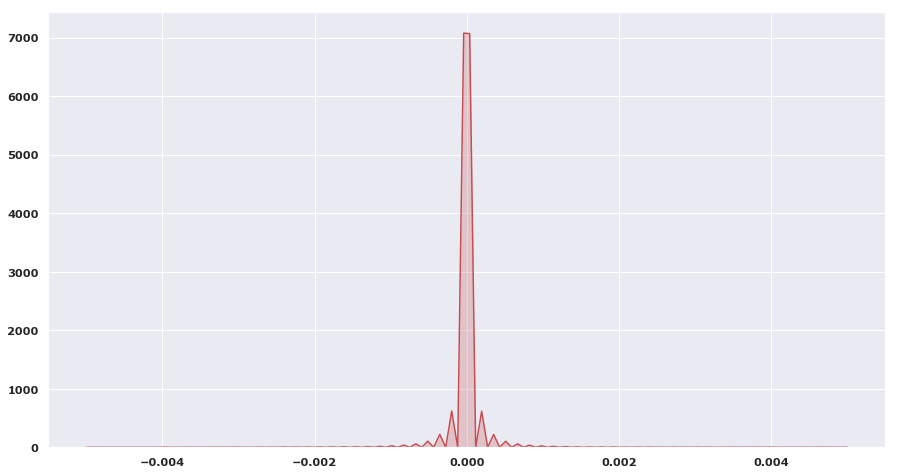

In [17]:
sns.kdeplot(tdf["usd_goal_real ratio"] - tdf["usd_pledged_real ratio"], shade=True, color="r")

In [119]:
tdf[~(tdf["usd_pledged_real ratio"] == tdf["usd_goal_real ratio"])].head()

,name,category,main_category,currency,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,usd pledged ratio,usd_pledged_real ratio,usd_goal_real ratio
deadline,,,,,,,,,,,,,,,,
2017-05-03,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,5000.0,2017-04-05 19:44:18,94175.00,successful,761,GB,57763.78,121857.33,6469.73,0.613366,1.293946,1.293946
2017-09-07,MikeyJ clothing brand fundraiser,Childrenswear,Fashion,AUD,2500.0,2017-08-08 01:20:20,1.00,failed,1,AU,0.00,0.81,2026.10,0.000000,0.810000,0.810440
2015-02-25,Mountain brew: A quest for alcohol sustainability,Drinks,Food,NOK,500.0,2015-01-26 19:17:33,48.00,failed,3,NO,6.18,6.29,65.55,0.128750,0.131042,0.131100
2014-12-14,Permaculture Skills,Webseries,Film & Video,CAD,17757.0,2014-11-14 18:02:00,48905.00,successful,571,CA,43203.25,42174.03,15313.04,0.883412,0.862366,0.862366
2016-01-28,Rebel Army Origins: The Heroic Story Of Major ...,Comics,Comics,GBP,100.0,2015-12-29 16:59:29,112.38,successful,27,GB,167.70,160.60,142.91,1.492258,1.429080,1.429100


Ладно, выкинем!

In [19]:
cdf = df[["launched", "deadline", "main_category", "category", "name", "currency", "country", "usd_goal_real", "usd_pledged_real", "backers", "state"]]

In [20]:
cdf = cdf.rename(columns={"usd_goal_real": "goal", "usd_pledged_real": "pledged"})

In [21]:
cdf.head()

,launched,deadline,main_category,category,name,currency,country,goal,pledged,backers,state
ID,,,,,,,,,,,
1000002330,2015-08-11 12:12:28,2015-10-09,Publishing,Poetry,The Songs of Adelaide & Abullah,GBP,GB,1533.95,0.0,0,failed
1000003930,2017-09-02 04:43:57,2017-11-01,Film & Video,Narrative Film,Greeting From Earth: ZGAC Arts Capsule For ET,USD,US,30000.00,2421.0,15,failed
1000004038,2013-01-12 00:20:50,2013-02-26,Film & Video,Narrative Film,Where is Hank?,USD,US,45000.00,220.0,3,failed
1000007540,2012-03-17 03:24:11,2012-04-16,Music,Music,ToshiCapital Rekordz Needs Help to Complete Album,USD,US,5000.00,1.0,1,failed
1000011046,2015-07-04 08:35:03,2015-08-29,Film & Video,Film & Video,Community Film Project: The Art of Neighborhoo...,USD,US,19500.00,1283.0,14,canceled


## Проверка на откровенную лажу

Проверка нанов:

In [22]:
cdf[cdf.isna().any(axis=1)]

,launched,deadline,main_category,category,name,currency,country,goal,pledged,backers,state
ID,,,,,,,,,,,
1848699072,2012-01-01 12:35:31,2012-02-29,Film & Video,Narrative Film,NaN,USD,US,200000.00,100.00,1,failed
634871725,2012-12-19 23:57:48,2013-01-06,Games,Video Games,NaN,GBP,GB,3224.97,316.05,12,failed
648853978,2016-06-18 05:01:47,2016-07-18,Design,Product Design,NaN,USD,US,2500.00,0.00,0,suspended
796533179,2011-11-06 23:55:55,2011-12-05,Art,Painting,NaN,USD,US,35000.00,220.00,5,failed


In [23]:
cdf.dropna(inplace=True)

Обнаружились подозрительные даты:

In [24]:
cdf[pd.to_datetime(cdf.launched).dt.year < 2008]

,launched,deadline,main_category,category,name,currency,country,goal,pledged,backers,state
ID,,,,,,,,,,,
1014746686,1970-01-01 01:00:00,2010-09-15,Film & Video,Film & Video,Salt of the Earth: A Dead Sea Movie (Canceled),USD,US,5000.00,0.0,0,canceled
1245461087,1970-01-01 01:00:00,2010-08-14,Art,Art,1st Super-Size Painting - Social Network Owned...,USD,US,15000.00,0.0,0,canceled
1384087152,1970-01-01 01:00:00,2010-05-21,Film & Video,Film & Video,"""ICHOR"" (Canceled)",USD,US,700.00,0.0,0,canceled
1480763647,1970-01-01 01:00:00,2010-06-01,Theater,Theater,"Support Solo Theater! Help ""Ungrateful Daughte...",USD,US,4000.00,0.0,0,canceled
330942060,1970-01-01 01:00:00,2010-05-04,Music,Music,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",USD,US,10000.00,0.0,0,canceled
462917959,1970-01-01 01:00:00,2010-04-10,Design,Design,Identity Communications Infographic (Canceled),USD,US,500.00,0.0,0,canceled
69489148,1970-01-01 01:00:00,2015-10-31,Publishing,Publishing,Student Auditions Music 2015,CHF,CH,1905.97,0.0,0,suspended


In [25]:
cdf = cdf[pd.to_datetime(cdf.launched).dt.year >= 2008]

Обнаружилась подозрительная страна: "N,0''"

In [26]:
cdf.country.value_counts()

US      292618
GB       33671
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         760
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

Более того, с этой страной есть странная вещь в данных: есть проекты, в которых 0 человек занесло больше 0 долларов. Покровители есть, денег нет...

In [27]:
cdf[(cdf.pledged > 0) & (cdf.backers == 0)].country.value_counts()

N,0"    3079
US         3
Name: country, dtype: int64

Будем иметь эту необычную страну и явление в виду.

# Категории

Напишем полезную функцию для отображения динамики категориальных признаков во времени:

In [28]:
def plot_time(cat_feature):
    cdf.launched = pd.to_datetime(cdf.launched).dt.date
    beginings = cdf.set_index("launched")[[cat_feature]]
    beginings["change"] = 1

    cdf.deadline = pd.to_datetime(cdf.deadline).dt.date
    ends = cdf.set_index("deadline")[[cat_feature]]
    ends["change"] = -1
    sdf = pd.concat([beginings, ends]).sort_index()
    sdf = sdf[:cdf.launched.max()]

    counted = set()
    prev_val = np.zeros((len(sdf)))

    for cat in df[cat_feature].unique():
        counted.add(cat)
        change = sdf.change.copy()
        change[sdf[cat_feature].map(lambda x: not x in counted)] = 0
        change.cumsum().plot(label=cat)

        val = change.cumsum().values
        plt.fill_between(sdf.index, prev_val, val, edgecolor='none')
        prev_val = val
    
    plt.legend()

In [29]:
def invert_legend():  # инвертирование легенды: понадобится
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])

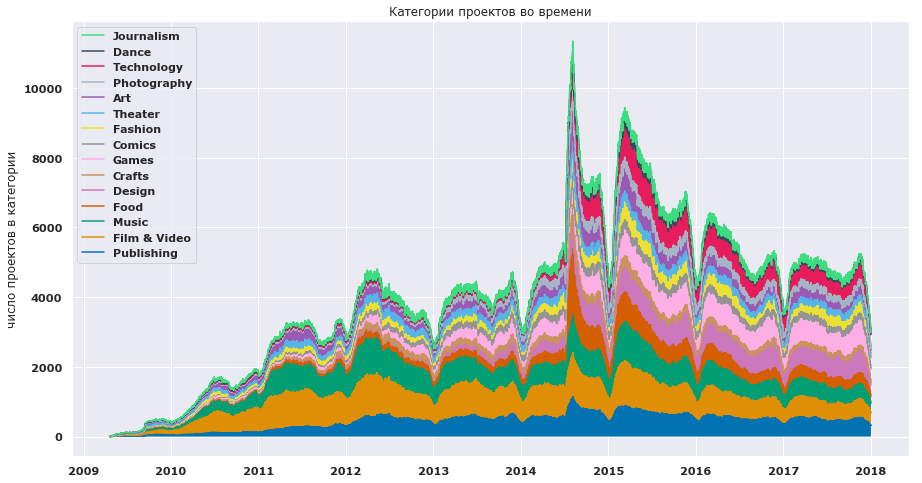

In [30]:
plot_time("main_category")
plt.ylabel("число проектов в категории")
plt.title("Категории проектов во времени")

invert_legend()
plt.savefig("e_categories_bad.png", bbox_inches='tight')

Какая ужасная цветовая палитра этот ваш colorblind!

In [57]:
sns.set_palette(sns.color_palette("Blues"))

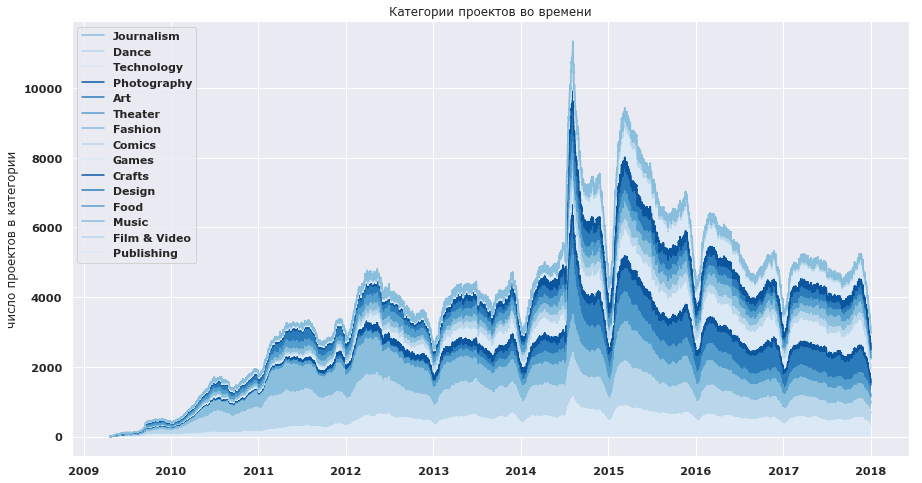

In [32]:
plot_time("main_category")
plt.ylabel("число проектов в категории")
plt.title("Категории проектов во времени")

invert_legend()
plt.savefig("e_categories.png", bbox_inches='tight')

In [60]:
sns.set_palette(sns.cubehelix_palette(8, start=.5, rot=-.75))

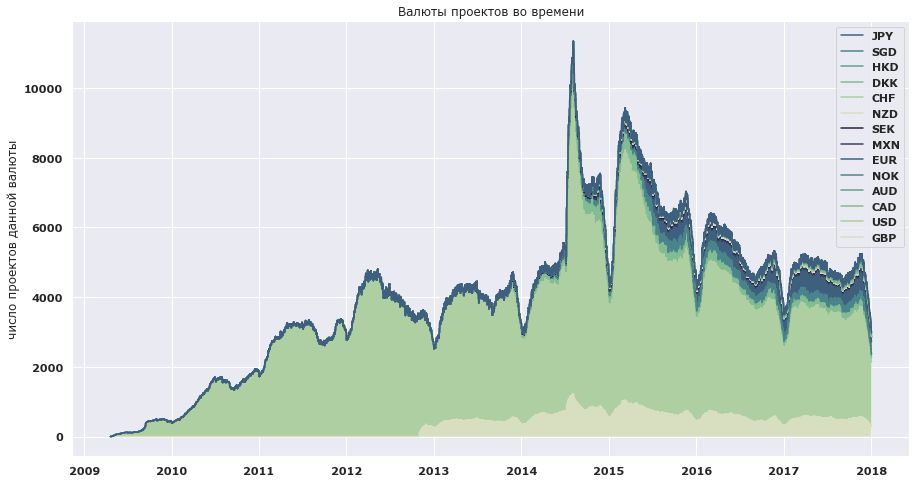

In [61]:
plot_time("currency")
plt.ylabel("число проектов данной валюты")
plt.title("Валюты проектов во времени")
invert_legend()

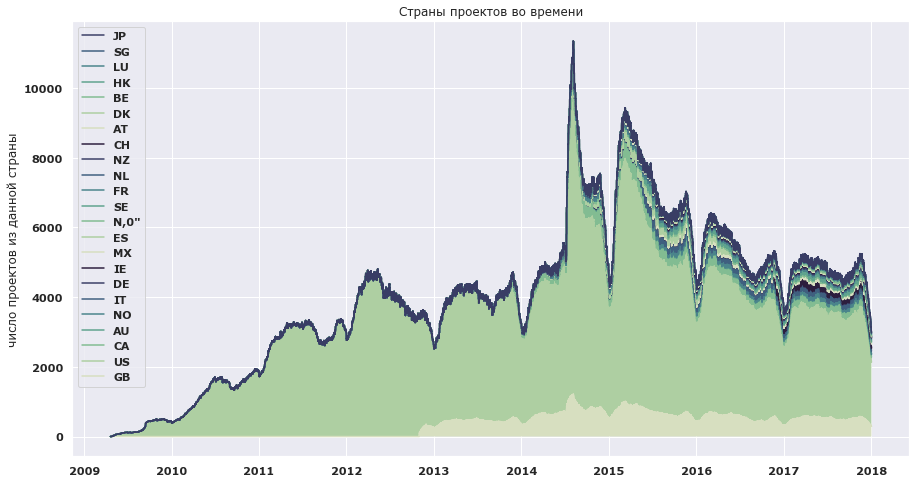

In [62]:
plot_time("country")
plt.ylabel("число проектов из данной страны")
plt.title("Страны проектов во времени")
invert_legend()

In [79]:
sat = 0.6
transp = 0.75
sns.set_palette([(sat, 0, 0, transp), (sat, sat, 0, transp), (0, 0, sat, transp), (0, sat, 0, transp)])

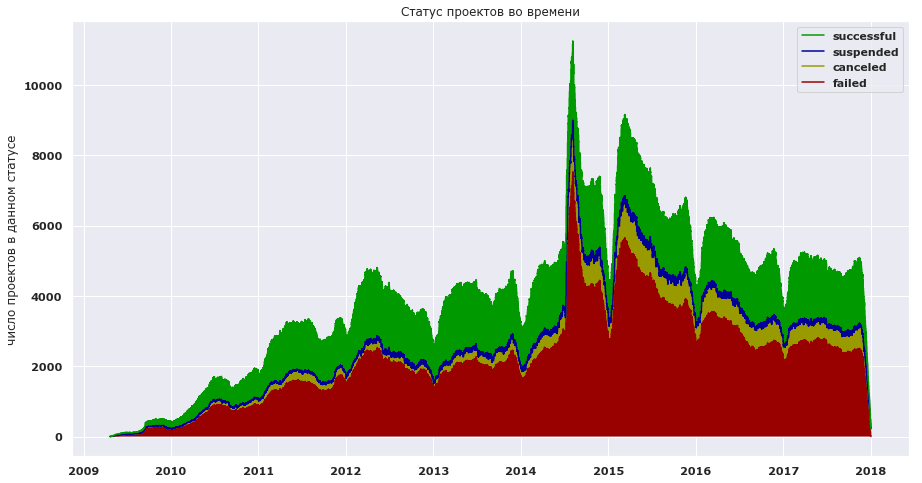

In [80]:
cat_feature = "state"
cdf.launched = pd.to_datetime(cdf.launched).dt.date
beginings = cdf.set_index("launched")[[cat_feature]]
beginings["change"] = 1

cdf.deadline = pd.to_datetime(cdf.deadline).dt.date
ends = cdf.set_index("deadline")[[cat_feature]]
ends["change"] = -1
sdf = pd.concat([beginings, ends]).sort_index()
sdf = sdf[:cdf.launched.max()]

counted = set()
prev_val = np.zeros((len(sdf)))

for cat in ["failed", "canceled", "suspended", "successful"]:
    counted.add(cat)
    change = sdf.change.copy()
    change[sdf[cat_feature].map(lambda x: not x in counted)] = 0
    change.cumsum().plot(label=cat)

    val = change.cumsum().values
    plt.fill_between(sdf.index, prev_val, val, edgecolor='none')
    prev_val = val

plt.legend()

plt.ylabel("число проектов в данном статусе")
plt.title("Статус проектов во времени")
invert_legend()
plt.savefig("f_states.png", bbox_inches='tight')

In [55]:
sns.set_palette(sns.cubehelix_palette(20))

Text(0.5,1,'Самые популярные подкатегории')

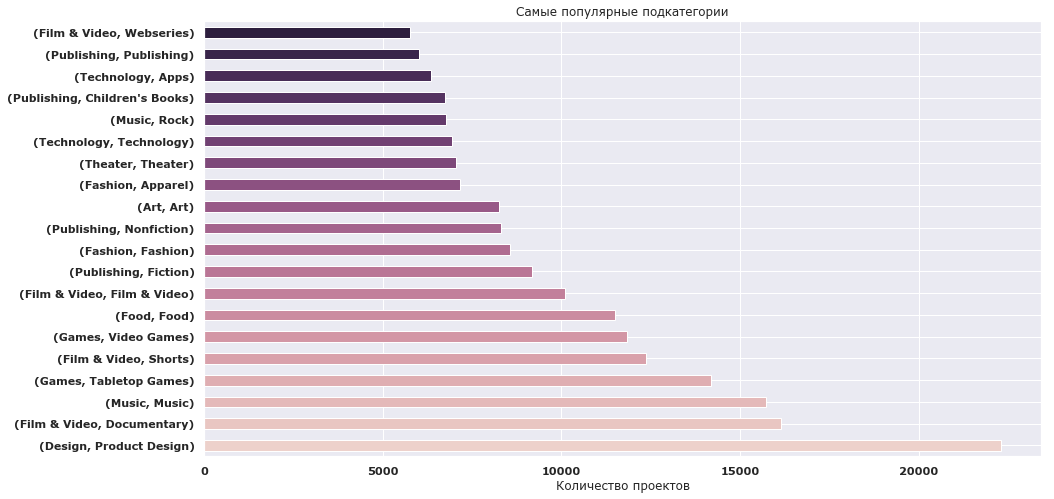

In [56]:
res = cdf.groupby(["main_category", "category"]).apply(len)
res.sort_values(ascending=False)[:20].plot(kind="barh")
plt.ylabel("")
plt.xlabel("Количество проектов")
plt.title("Самые популярные подкатегории")

# Подношения!

In [81]:
sns.set_palette(sns.color_palette("colorblind") + ["#9b59b6", "#a5b5c6", "#e71c5c", "#34495e", "#3edc81", "#507d50"])

Text(0.5,1,'Подношения')

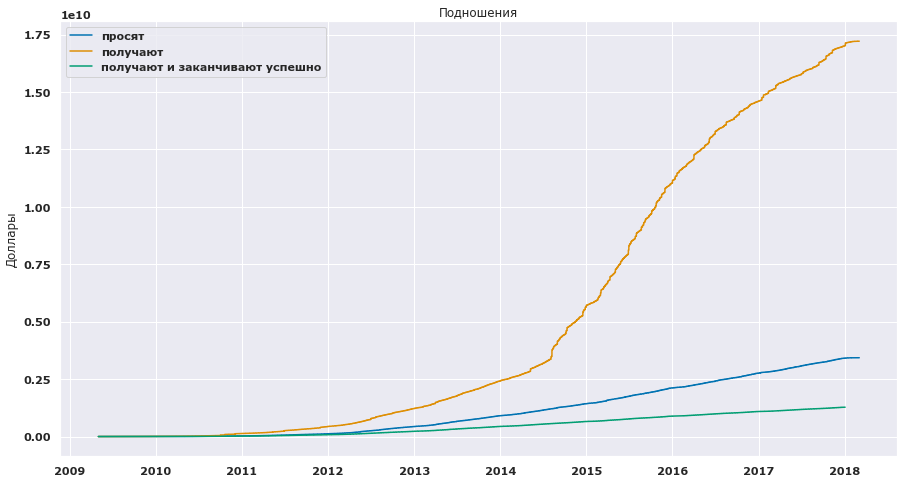

In [83]:
cdf.set_index("deadline")["pledged"].sort_index().cumsum().plot(label="просят")
cdf.set_index("deadline")["goal"].sort_index().cumsum().plot(label="получают")
cdf[cdf.state == "successful"].set_index("deadline")["goal"].sort_index().cumsum().plot(label="получают и заканчивают успешно")
plt.legend()
plt.xlabel("")
plt.ylabel("Доллары")
plt.title("Подношения")

Очень не хотелось применять логарифм к долларам, но пришлось!

In [84]:
ldf = cdf[cdf.pledged > 0].copy()
ldf.goal = ldf.goal.apply(np.log)
ldf.pledged = ldf.pledged.apply(np.log)

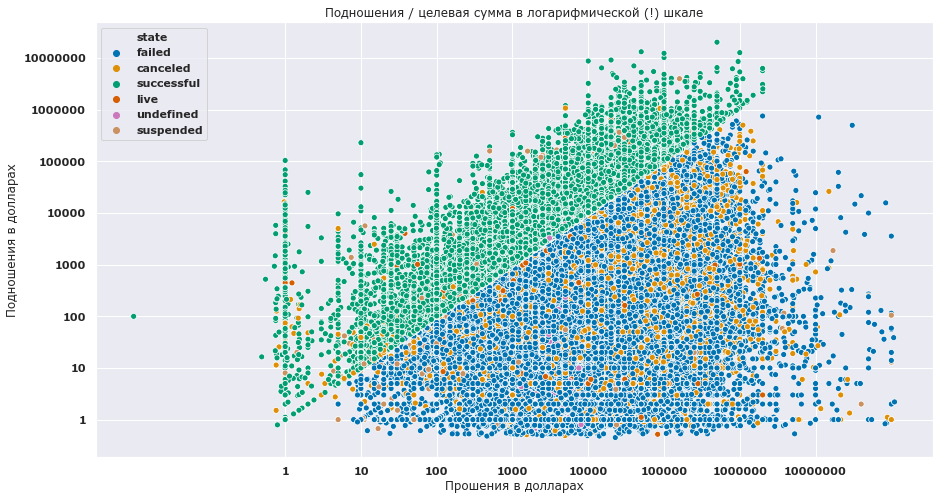

In [86]:
sns.scatterplot("goal", "pledged", hue="state", data=ldf)
plt.xlabel("Прошения в долларах")
plt.ylabel("Подношения в долларах")
plt.title("Подношения / целевая сумма в логарифмической (!) шкале")
plt.xticks(np.log(10**np.arange(8)), 10**np.arange(8))
plt.yticks(np.log(10**np.arange(8)), 10**np.arange(8))
plt.savefig("g_pledged2goal.png", bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


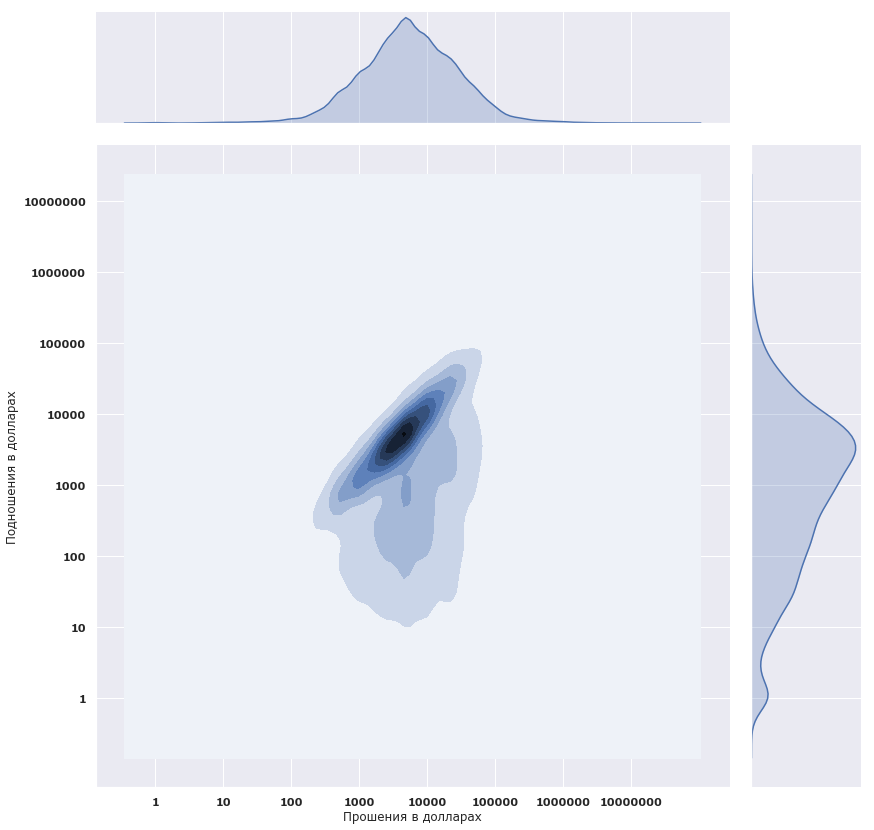

In [87]:
g = sns.jointplot(x="goal", y="pledged", data=ldf.sample(10000), kind="kde", height=12, color="b")

g.ax_joint.set_xticks(ticks=np.log(10**np.arange(8)))
g.ax_joint.set_yticks(ticks=np.log(10**np.arange(8)))
g.ax_joint.set_xticklabels(10**np.arange(8))
g.ax_joint.set_yticklabels(10**np.arange(8));
g.ax_joint.set_xlabel("Прошения в долларах")
g.ax_joint.set_ylabel("Подношения в долларах")
plt.savefig("h_pledged2goal_density.png", bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


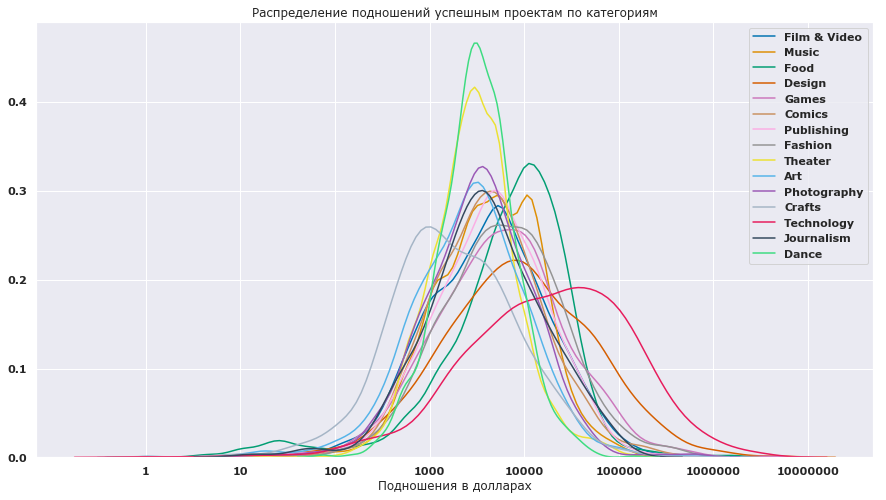

In [88]:
for cat in ldf.main_category.unique():
    sns.distplot(ldf[(ldf.state == "successful") & (ldf.category == cat)].pledged, hist=False, label=cat)
plt.legend()
plt.xlabel("Подношения в долларах")
plt.xticks(np.log(10**np.arange(8)), 10**np.arange(8))
plt.title("Распределение подношений успешным проектам по категориям")
plt.savefig("i_pledgedByCategory.png", bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Распределение подношений во всех проектах по категориям')

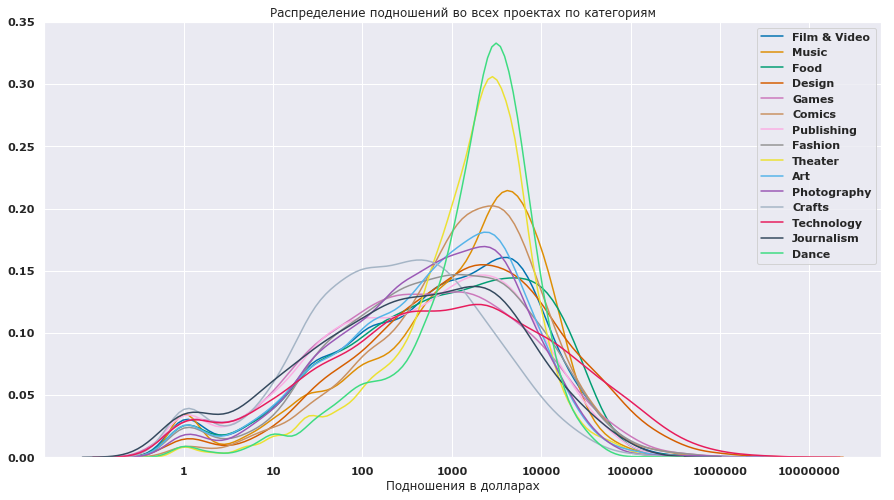

In [43]:
for cat in ldf.main_category.unique():
    sns.distplot(ldf[(ldf.category == cat)].pledged, hist=False, label=cat)
plt.legend()
plt.xlabel("Подношения в долларах")
plt.xticks(np.log(10**np.arange(8)), 10**np.arange(8))
plt.title("Распределение подношений во всех проектах по категориям")

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Распределение целевой суммы во всех проектах по категориям')

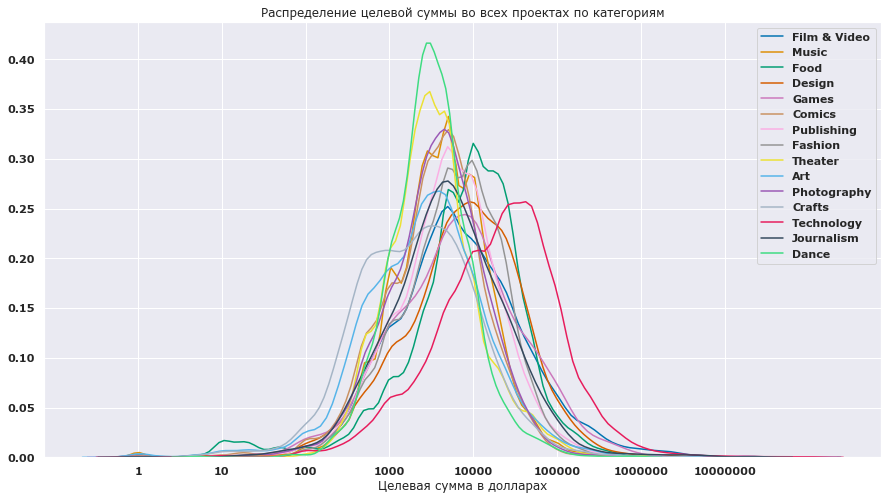

In [89]:
for cat in ldf.main_category.unique():
    sns.distplot(ldf[(ldf.category == cat)].goal, hist=False, label=cat)
plt.legend()
plt.xlabel("Целевая сумма в долларах")
plt.xticks(np.log(10**np.arange(8)), 10**np.arange(8))
plt.title("Распределение целевой суммы во всех проектах по категориям")

Означает ли это, что самый успешный проект - это "технологии"?

In [98]:
sns.set_palette(sns.cubehelix_palette(15))

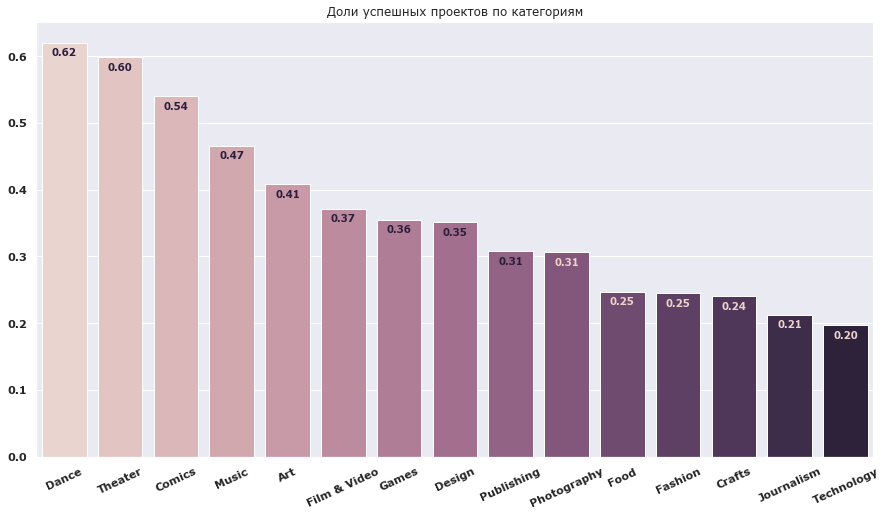

In [118]:
plt.title("Доли успешных проектов по категориям")

sr = (cdf[cdf.state == "successful"].main_category.value_counts() / cdf.main_category.value_counts())
sr = sr.sort_values(ascending=False)
ax = sns.barplot(sr.index, sr.values)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height - 0.02,
            '{:1.2f}'.format(height),
            ha="center", size=10, color=sns.color_palette()[-1 if i < 9 else 0])
    
plt.xticks(rotation=25)
plt.savefig("j_successrate.png", bbox_inches='tight')

Ровно наоборот!

In [90]:
ccdf = cdf[(cdf.pledged > 0) & (cdf.backers > 0)]

Text(0,0.5,'Категория')

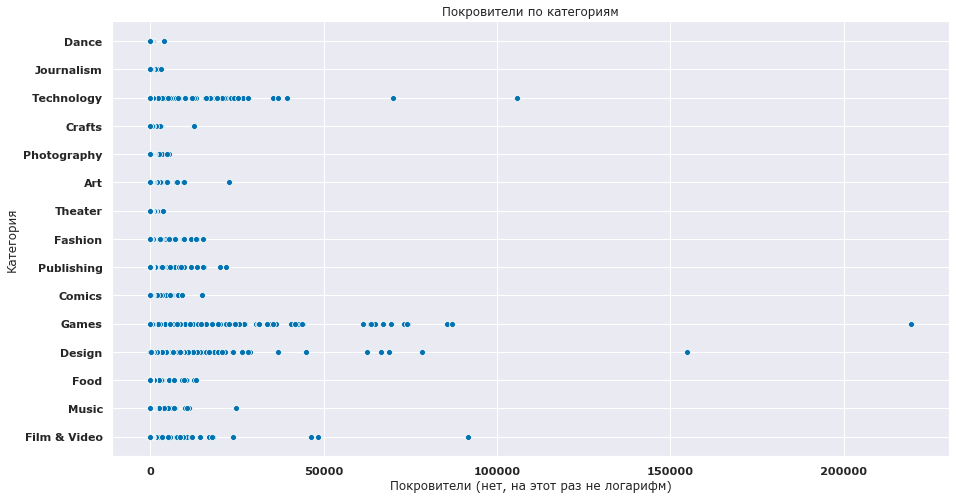

In [91]:
sns.scatterplot("backers", "main_category", data=ccdf)
plt.title("Покровители по категориям")
plt.xlabel("Покровители (нет, на этот раз не логарифм)")
plt.ylabel("Категория")

# Ну и для интереса

Топ самых крутых проектов!

In [47]:
cdf[cdf.state == "successful"].sort_values("pledged", ascending=False)[:5][["name", "main_category", "category", "goal", "pledged", "backers"]]

,name,main_category,category,goal,pledged,backers
ID,,,,,,
1799979574,"Pebble Time - Awesome Smartwatch, No Compromises",Design,Product Design,500000.0,20338986.27,78471
342886736,COOLEST COOLER: 21st Century Cooler that's Act...,Design,Product Design,50000.0,13285226.36,62642
2103598555,"Pebble 2, Time 2 + All-New Pebble Core",Design,Product Design,1000000.0,12779843.49,66673
545070200,Kingdom Death: Monster 1.5,Games,Tabletop Games,100000.0,12393139.69,19264
506924864,Pebble: E-Paper Watch for iPhone and Android,Design,Product Design,100000.0,10266845.74,68929
